In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [2]:
chunks = []
for i in range(1, 5):
    chunk = np.load(f"/project/deeprna/data/revision/imputation_benchmark_new_chunk{i}.npz", allow_pickle=True)
    chunks.append(chunk)

# Merge chunks
data = {}
for chunk in chunks:
    for key in chunk.keys():
        if key in ['region_coords','region_indices','model_names','experiments','mean_baseline','tta_shifts','tta_rc']:
            if key not in data:
                data[key] = chunk[key]
            else:
                assert np.array_equal(data[key], chunk[key]), f"Mismatch in {key}"
        elif key == 'tissues':
            if key not in data:
                data[key] = chunk[key]
            else:
                data[key] = np.concatenate([data[key], chunk[key]], axis=0)
        elif key in ['ground_truth', 'corgi_family_preds', 'epigept_preds']:
            if key not in data:
                data[key] = chunk[key]
            else:
                data[key] = np.concatenate([data[key], chunk[key]], axis=2)     # Concat along tissue axis

# Add avocado
avocado = np.load(f"/project/deeprna/data/revision/imputation_benchmark_new_avocado.npz", allow_pickle=True)
for key in ['tissues','region_coords','experiments','region_indices']:
    assert np.array_equal(data[key], avocado[key]), f"Mismatch in {key} between merged chunks and avocado data"

data['avocado_preds'] = np.clip(avocado['avocado_preds'], a_min=0, a_max=None)  # Clip negative values to zero

In [3]:
# Print shapes
for key in ['mean_baseline', 'ground_truth', 'corgi_family_preds', 'epigept_preds', 'avocado_preds']:
    print(f"{key}: {data[key].shape}")
del chunks
del avocado

mean_baseline: (1, 640, 6144, 22)
ground_truth: (1, 640, 14, 6144, 22)
corgi_family_preds: (5, 640, 14, 6144, 22)
epigept_preds: (1, 640, 14, 3000, 22)
avocado_preds: (1, 640, 14, 6144, 22)


In [4]:
# Channels
for i, exp in enumerate(data['experiments']):
    print(f"{i}: {exp}")

0: dnase
1: atac
2: h3k4me1
3: h3k4me2
4: h3k4me3
5: h3k9ac
6: h3k9me3
7: h3k27ac
8: h3k27me3
9: h3k36me3
10: h3k79me2
11: ctcf
12: cage_plus
13: cage_minus
14: rampage_plus
15: rampage_minus
16: rna_total_plus
17: rna_total_minus
18: rna_polya_plus
19: rna_polya_minus
20: rna_10x
21: wgbs


## Fig. 4B

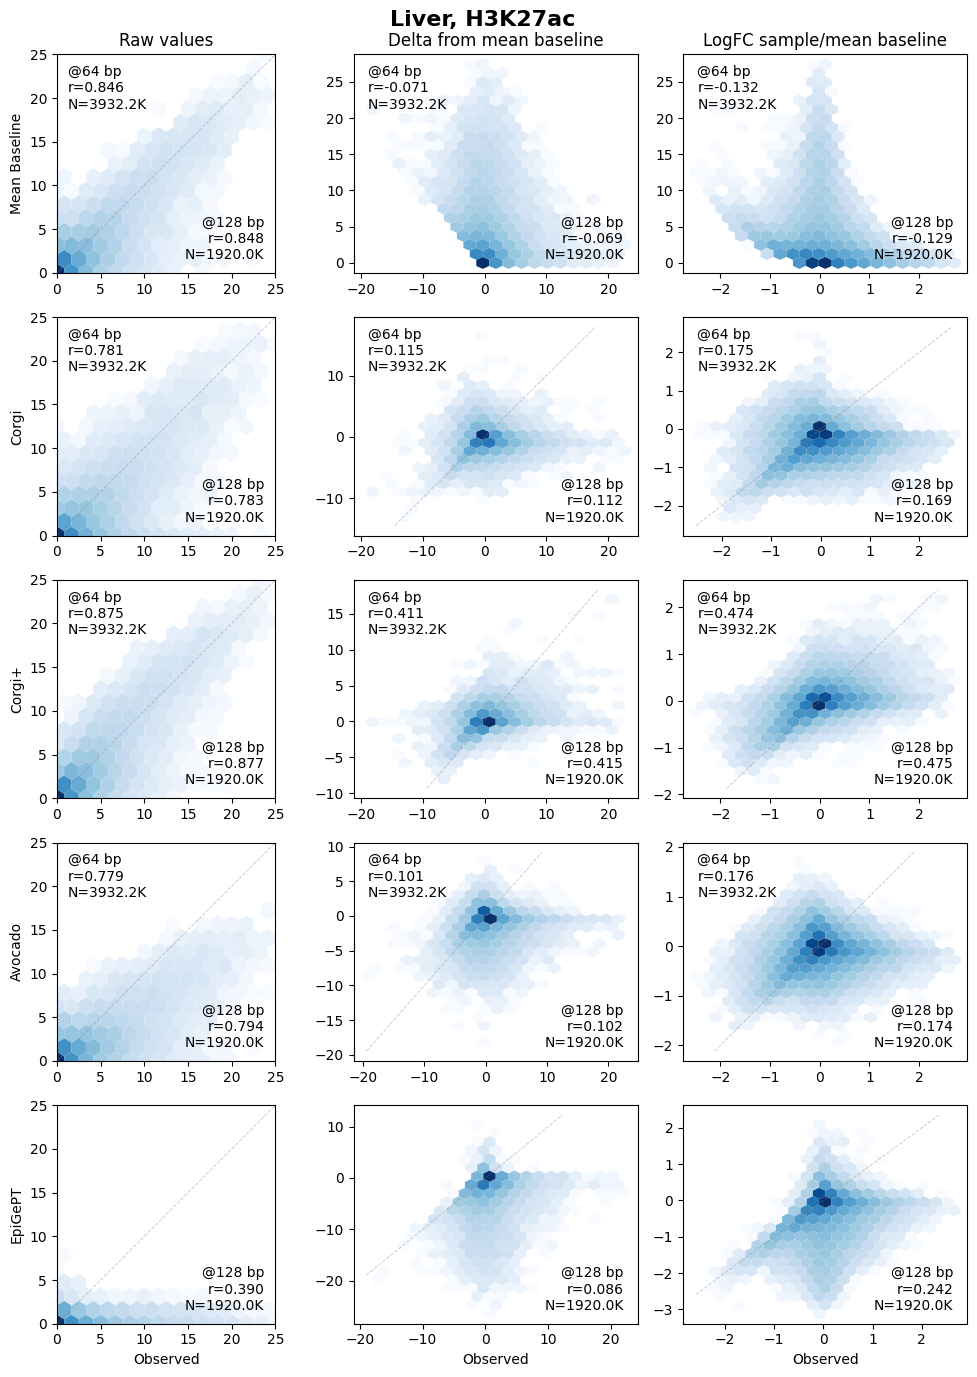

In [11]:
tissue = data['tissues'].tolist().index(50)     # Liver
channel = 0                                      # H3K27ac

# Figure 4: Scatter plots of predictions vs ground truth
# 5 rows: mean baseline, Corgi, Corgi+, Avocado, Epigept
# 3 columns: raw, delta, logFC
# Write in the plot: pearson r, spearman rho, N (top left). r and rho and N at 128bp res. (bottom right) (for epigept: only bottom right)

fig, axes = plt.subplots(5, 3, figsize=(10, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Col 1
lim = 25
x = data['ground_truth'][0, :, tissue, :, channel].flatten()
y_mean = data['mean_baseline'][0,:, :, channel].flatten()
y_corgi1 = data['corgi_family_preds'][0, :, tissue, :, channel].flatten()
y_corgi4 = data['corgi_family_preds'][4, :, tissue, :, channel].flatten()
y_avocado = data['avocado_preds'][0, :, tissue, :, channel].flatten()
y_epigept_128 = data['epigept_preds'][0, :, tissue, :, channel].flatten() # At 128 bp res. 3000 values per region

# For 128bp resolution, first crop to middle 6000 bins, then mean pool k=2
x_128 = data['ground_truth'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
y_mean_128 = data['mean_baseline'][0, :, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
y_corgi1_128 = data['corgi_family_preds'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
y_corgi4_128 = data['corgi_family_preds'][4, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
y_avocado_128 = data['avocado_preds'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)

for row, (y1, y2) in enumerate(zip([y_mean, y_corgi1, y_corgi4, y_avocado],[y_mean_128, y_corgi1_128, y_corgi4_128, y_avocado_128])):
    model_names = ["Mean Baseline", "Corgi", "Corgi+", "Avocado"]

    # Col 1
    lim = 25
    axes[row, 0].hexbin(x, y1, gridsize=15, cmap='Blues', bins='log', mincnt=5, edgecolors='none', extent=(0,lim,0,lim))
    axes[row, 0].set_xlabel("")
    axes[row, 0].set_ylabel(f"{model_names[row]}")
    axes[row, 0].set_aspect('equal', adjustable='box')

    # Correlations
    r, _ = pearsonr(x, y1)
    N = len(y1)
    r_128, _ = pearsonr(x_128, y2)
    N_128 = len(y2)

    # 64bp to top left, 128bp to bottom right
    axes[row, 0].text(0.05, 0.95, f"@64 bp\nr={r:.3f}\nN={N/1e3:.1f}K", transform=axes[row, 0].transAxes,
                     verticalalignment='top')
    axes[row, 0].text(0.95, 0.05, f"@128 bp\nr={r_128:.3f}\nN={N_128/1e3:.1f}K", transform=axes[row, 0].transAxes,
                     verticalalignment='bottom', horizontalalignment='right')
    
    axes[row, 0].set_xlim(0, lim)
    axes[row, 0].set_ylim(0, lim)
    axes[row, 0].plot([0, lim], [0, lim], '--', alpha=0.4, color='gray', linewidth=0.7)

    # Col 2
    if row == 0:
        axes[row, 0].set_title("Raw values")
        axes[row, 1].set_title("Delta from mean baseline")
        axes[row, 2].set_title("LogFC sample/mean baseline")

        delta_x = x - y_mean
        delta_y1 = y_mean
        delta_x_128 = x_128 - y_mean_128
        delta_y2 = y_mean_128
    else:
        delta_x = x - y_mean
        delta_y1 = y1 - y_mean
        delta_x_128 = x_128 - y_mean_128
        delta_y2 = y2 - y_mean_128

    # plot x=y line
    axes[row, 1].hexbin(delta_x, delta_y1, gridsize=20, cmap='Blues', bins='log', mincnt=1, edgecolors='none')
    xlim = axes[row, 1].get_xlim()
    ylim = axes[row, 1].get_ylim()
    left_corner = max(xlim[0], ylim[0])
    right_corner = min(xlim[1], ylim[1])
    if row != 0:
        axes[row, 1].plot([left_corner, right_corner], [left_corner, right_corner], '--', alpha=0.4, color='gray', linewidth=0.7)
    axes[row, 1].set_xlabel("")
    axes[row, 1].set_ylabel("")
    
    # Correlations
    r_delta, _ = pearsonr(delta_x, delta_y1)
    N_delta = len(delta_y1)
    r_delta_128, _ = pearsonr(delta_x_128, delta_y2)
    N_delta_128 = len(delta_y2)

    # 64bp to top left, 128bp to bottom right
    axes[row, 1].text(0.05, 0.95, f"@64 bp\nr={r_delta:.3f}\nN={N_delta/1e3:.1f}K", transform=axes[row, 1].transAxes,
                     verticalalignment='top')
    axes[row, 1].text(0.95, 0.05, f"@128 bp\nr={r_delta_128:.3f}\nN={N_delta_128/1e3:.1f}K", transform=axes[row, 1].transAxes,
                     verticalalignment='bottom', horizontalalignment='right')
    
    # Col 3
    if row == 0:
        logfc_x = np.log(x + 1) - np.log(y_mean + 1)
        logfc_y1 = y_mean
        logfc_x_128 = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y2 = y_mean_128
    else:
        logfc_x = np.log(x + 1) - np.log(y_mean + 1)
        logfc_y1 = np.log(y1 + 1) - np.log(y_mean + 1)
        logfc_x_128 = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y2 = np.log(y2 + 1) - np.log(y_mean_128 + 1)

    axes[row, 2].hexbin(logfc_x, logfc_y1, gridsize=20, cmap='Blues', bins='log', mincnt=1, edgecolors='none')
    xlim = axes[row, 2].get_xlim()
    ylim = axes[row, 2].get_ylim()
    left_corner = max(xlim[0], ylim[0])
    right_corner = min(xlim[1], ylim[1])
    if row != 0:
        axes[row, 2].plot([left_corner, right_corner], [left_corner, right_corner], '--', alpha=0.4, color='gray', linewidth=0.7)
    axes[row, 2].set_xlabel("")
    axes[row, 2].set_ylabel("")

    # Correlations
    r_logfc, _ = pearsonr(logfc_x, logfc_y1)
    N_logfc = len(logfc_y1)
    r_logfc_128, _ = pearsonr(logfc_x_128, logfc_y2)
    N_logfc_128 = len(logfc_y2)

    # 64bp to top left, 128bp to bottom right
    axes[row, 2].text(0.05, 0.95, f"@64 bp\nr={r_logfc:.3f}\nN={N_logfc/1e3:.1f}K", transform=axes[row, 2].transAxes,
                     verticalalignment='top')
    axes[row, 2].text(0.95, 0.05, f"@128 bp\nr={r_logfc_128:.3f}\nN={N_logfc_128/1e3:.1f}K", transform=axes[row, 2].transAxes,
                     verticalalignment='bottom', horizontalalignment='right')
    
# Epigept row
axes[4, 0].hexbin(x_128, y_epigept_128, gridsize=15, cmap='Blues', bins='log', mincnt=5, edgecolors='none', extent=(0,lim,0,lim))

r_epigept_128, _ = pearsonr(x_128, y_epigept_128)
N_epigept_128 = len(y_epigept_128)

axes[4, 0].text(0.95, 0.05, f"@128 bp\nr={r_epigept_128:.3f}\nN={N_epigept_128/1e3:.1f}K", transform=axes[4, 0].transAxes,
                 verticalalignment='bottom', horizontalalignment='right')
axes[4, 0].set_xlabel("")
axes[4, 0].set_ylabel("EpiGePT")
axes[4, 0].set_xlim(0, lim)
axes[4, 0].set_ylim(0, lim)
axes[4, 0].plot([0, lim], [0, lim], '--', alpha=0.4, color='gray', linewidth=0.7)
axes[4, 0].set_aspect('equal', adjustable='box')

# Col 2
delta_y_epigept = y_epigept_128 - y_mean_128
delta_x_128 = x_128 - y_mean_128
axes[4, 1].hexbin(delta_x_128, delta_y_epigept, gridsize=20, cmap='Blues', bins='log', mincnt=1, edgecolors='none')
r_delta_epigept_128, _ = pearsonr(delta_x_128, delta_y_epigept)
N_delta_epigept_128 = len(delta_y_epigept)
axes[4, 1].text(0.95, 0.05, f"@128 bp\nr={r_delta_epigept_128:.3f}\nN={N_delta_epigept_128/1e3:.1f}K", transform=axes[4, 1].transAxes,
                 verticalalignment='bottom', horizontalalignment='right')
axes[4, 1].set_xlabel("")
axes[4, 1].set_ylabel("")

left_corner = max(axes[4, 1].get_xlim()[0], axes[4, 1].get_ylim()[0])
right_corner = min(axes[4, 1].get_xlim()[1], axes[4, 1].get_ylim()[1])
axes[4, 1].plot([left_corner, right_corner], [left_corner, right_corner], '--', alpha=0.4, color='gray', linewidth=0.7)

# Col 3
logfc_y_epigept = np.log(y_epigept_128 + 1) - np.log(y_mean_128 + 1)
logfc_x_128 = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
axes[4, 2].hexbin(logfc_x_128, logfc_y_epigept, gridsize=20, cmap='Blues', bins='log', mincnt=1, edgecolors='none')
r_logfc_epigept_128, _ = pearsonr(logfc_x_128, logfc_y_epigept)
N_logfc_epigept_128 = len(logfc_y_epigept)
axes[4, 2].text(0.95, 0.05, f"@128 bp\nr={r_logfc_epigept_128:.3f}\nN={N_logfc_epigept_128/1e3:.1f}K", transform=axes[4, 2].transAxes,
                 verticalalignment='bottom', horizontalalignment='right')
axes[4, 2].set_xlabel("")
axes[4, 2].set_ylabel("")
left_corner = max(axes[4, 2].get_xlim()[0], axes[4, 2].get_ylim()[0])
right_corner = min(axes[4, 2].get_xlim()[1], axes[4, 2].get_ylim()[1])
axes[4, 2].plot([left_corner, right_corner], [left_corner, right_corner], '--', alpha=0.4, color='gray', linewidth=0.7)

axes[4, 0].set_xlabel("Observed")
axes[4, 1].set_xlabel("Observed")
axes[4, 2].set_xlabel("Observed")

plt.suptitle('Liver, H3K27ac', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig("/project/deeprna/figures/revision/fig4/fig4b.pdf", dpi=300)
plt.show()

In [63]:
data['mean_baseline'].shape

(1, 640, 6144, 22)

## Fig. 4c

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


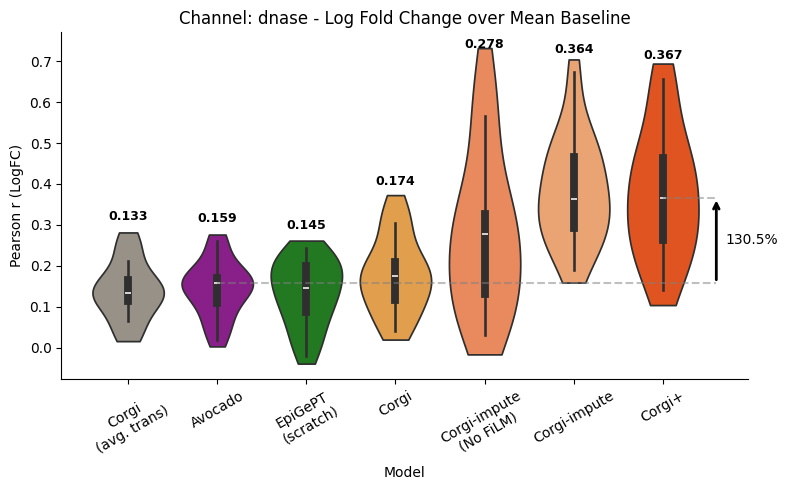

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


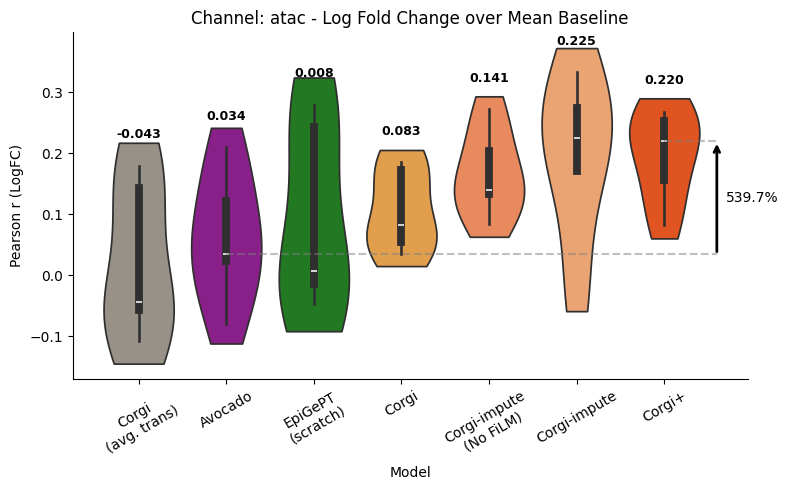

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


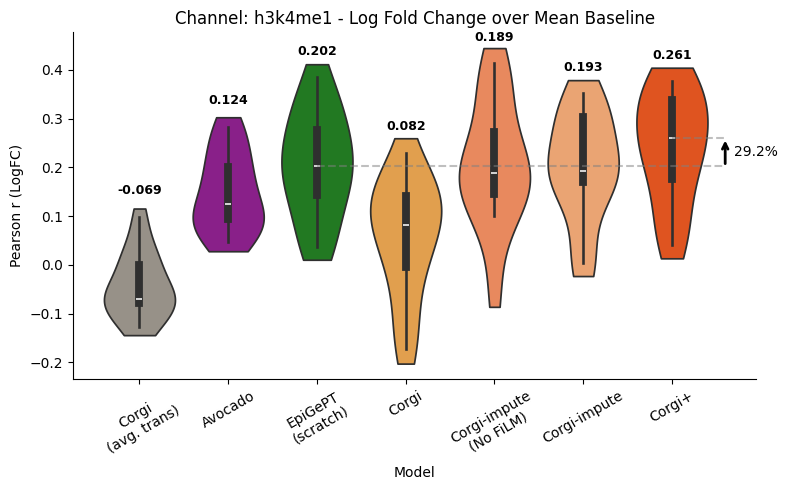

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


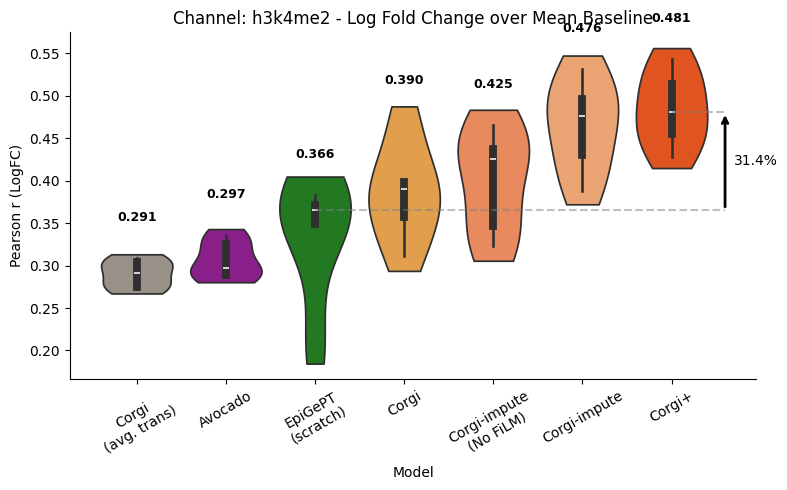

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


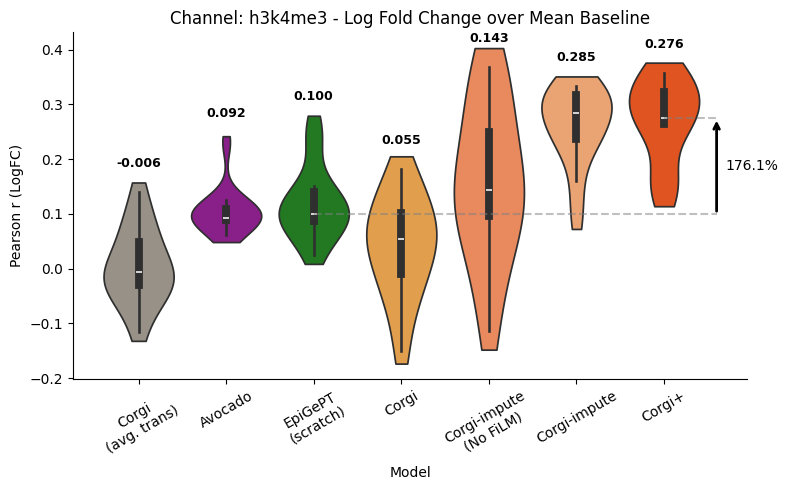

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


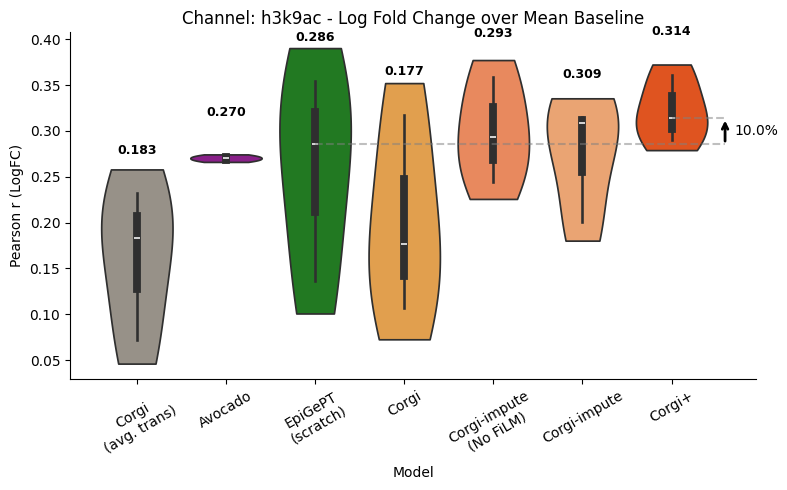

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


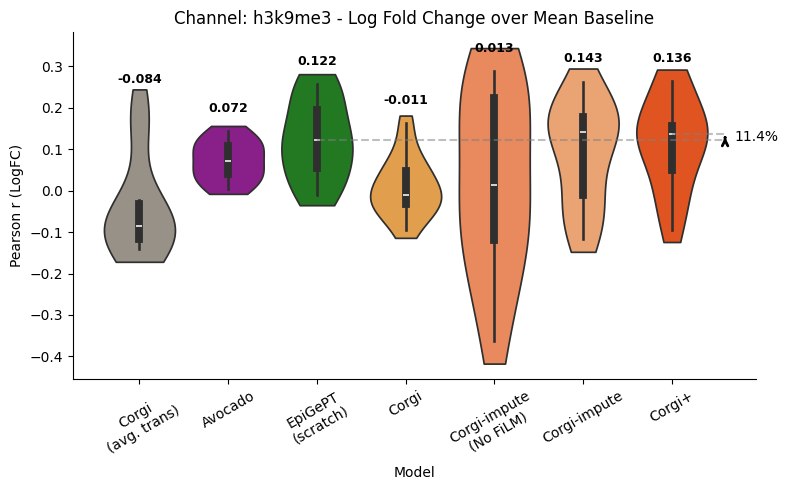

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


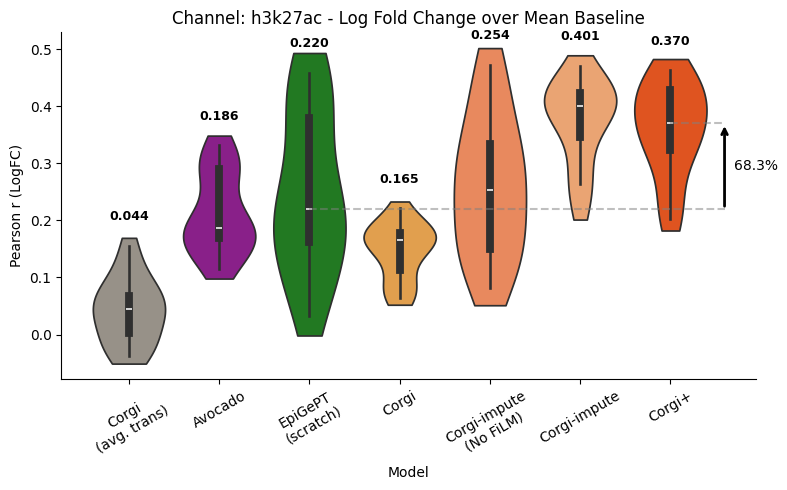

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


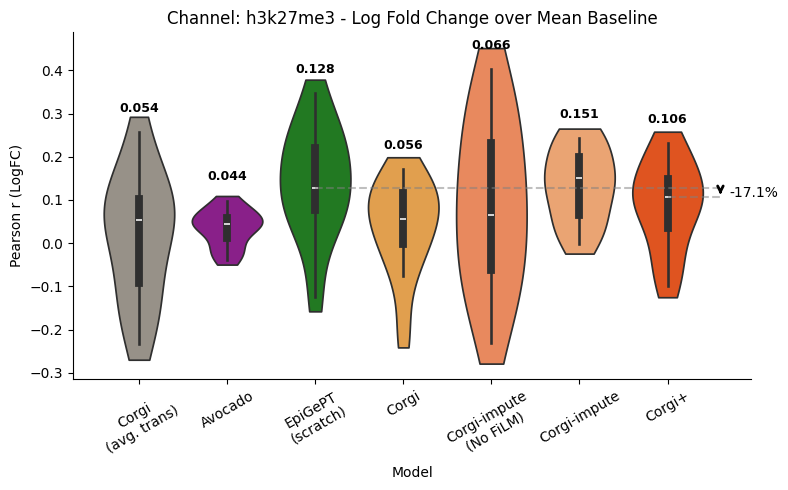

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


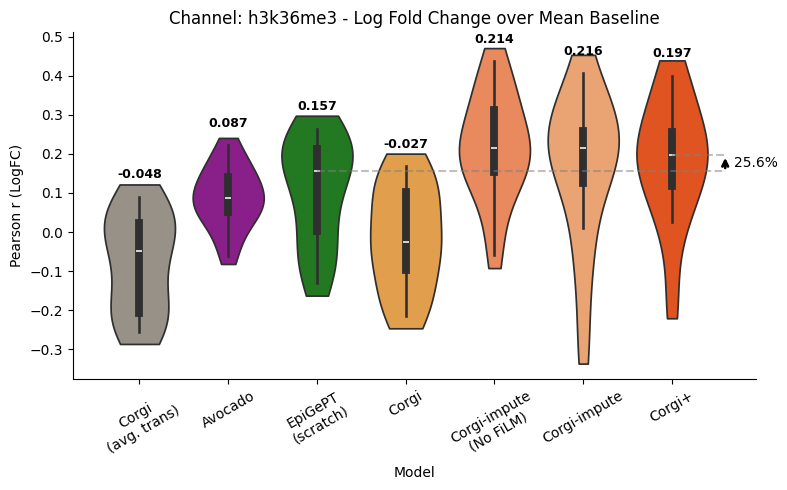

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


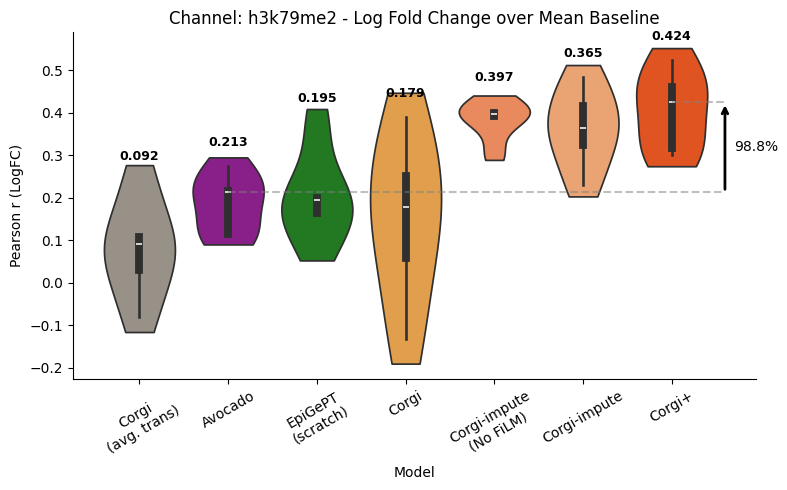

/scratch/local/ipykernel_109210/3167016724.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


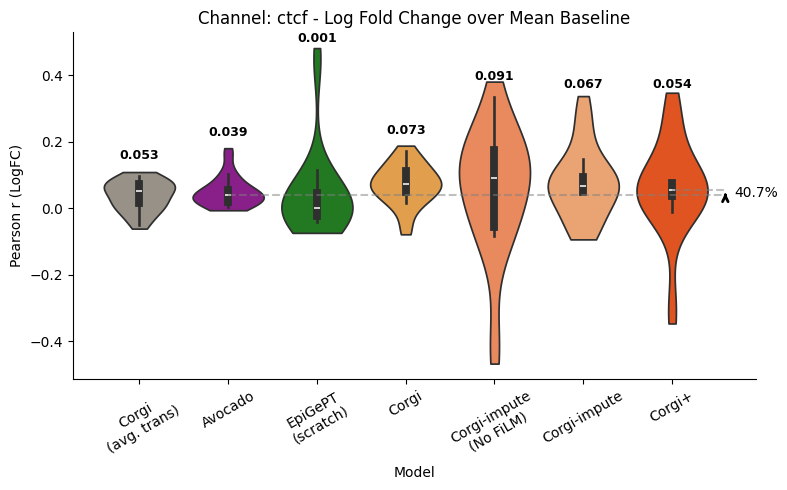

In [ ]:
# One plot per channel. Boxplots showing distribution of correlations across tissues.
# show logfc
# Order of models: corgi family in order (5 models), avocado, epigept
# All correlations at 128 bp resolution

model_names = ['Corgi avg. trans', 'Avocado', 'EpiGePT (scratch)', 'Corgi', 'Corgi-impute', 'Corgi-impute (No FiLM)', 'Corgi+']
model_order = ['Corgi avg. trans', 'Avocado', 'EpiGePT (scratch)', 'Corgi', 'Corgi-impute (No FiLM)', 'Corgi-impute', 'Corgi+']
# Colors: Corgi family orange shades, darkest is Corgi+. Epigept green, Avocado purple.
colors = ["#999286", "#9B0E9B", "#138813", "#FAA135", "#FEA15F", "#FF8147", '#FF4500']
channels = list(range(12))

for channel in channels:
    channel_name = data['experiments'][channel]
    corrs_delta = {model: [] for model in model_names}
    corrs_logfc = {model: [] for model in model_names}
    for tissue in range(data['ground_truth'].shape[2]):
        x_128 = data['ground_truth'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
        y_mean_128 = data['mean_baseline'][0, :, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)

        # Corgi family
        for i, model in enumerate(['Corgi avg. trans', 'Corgi', 'Corgi-impute', 'Corgi-impute (No FiLM)', 'Corgi+']):
            y_128 = data['corgi_family_preds'][i, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
            delta_x = x_128 - y_mean_128
            delta_y = y_128 - y_mean_128
            logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
            logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)

            r_delta, _ = pearsonr(delta_x, delta_y)
            r_logfc, _ = pearsonr(logfc_x, logfc_y)

            corrs_delta[model].append(r_delta)
            corrs_logfc[model].append(r_logfc)

        # Avocado
        y_128 = data['avocado_preds'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
        delta_x = x_128 - y_mean_128
        delta_y = y_128 - y_mean_128
        logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)

        r_delta, _ = pearsonr(delta_x, delta_y)
        r_logfc, _ = pearsonr(logfc_x, logfc_y)

        corrs_delta['Avocado'].append(r_delta)
        corrs_logfc['Avocado'].append(r_logfc)

        # Epigept
        y_128 = data['epigept_preds'][0, :, tissue, :, channel].flatten()
        delta_x = x_128 - y_mean_128
        delta_y = y_128 - y_mean_128
        logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)
        r_delta, _ = pearsonr(delta_x, delta_y)
        r_logfc, _ = pearsonr(logfc_x, logfc_y)
        corrs_delta['EpiGePT (scratch)'].append(r_delta)
        corrs_logfc['EpiGePT (scratch)'].append(r_logfc)

    # Convert to DataFrame for seaborn
    # df_delta = pd.DataFrame({model: corrs_delta[model] for model in model_names})
    # df_delta = df_delta.melt(var_name='Model', value_name='Pearson r (Delta)')
    df_logfc = pd.DataFrame({model: corrs_logfc[model] for model in model_names})
    df_logfc = df_logfc.melt(var_name='Model', value_name='Pearson r (LogFC)')

    # Plot
    fig, ax = plt.subplots(figsize=(8,5))
    sns.violinplot(x='Model', y='Pearson r (LogFC)', data=df_logfc, order=model_order, palette=colors, hue='Model', cut=0.4)
    ax.set_title(f"Channel: {channel_name} - Log Fold Change over Mean Baseline")

    # Find the best model from Avocado and Epigept. Then calculate percentage improvement between that and Corgi+
    # Draw transparent dashed line from the best model's median horizontally all the way to the right of the plot.
    # Draw a similar dashed line from Corgi+'s median to the right of the plot.
    # Draw an vertical arrow connecting the two. Write percentage improvement next to the arrow.
    # The dashed lines should begin at the x position at the best model, or Corgi+, and extend to the right edge of the plot.
    best_other_model_delta = max(df_logfc[df_logfc['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (LogFC)'].median())
    # which model is it? (for x value)
    best_model_x = df_logfc[df_logfc['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (LogFC)'].median().idxmax()
    corgi_plus_median_delta = df_logfc[df_logfc['Model'] == 'Corgi+']['Pearson r (LogFC)'].median()
    improvement_delta = (corgi_plus_median_delta - best_other_model_delta) / abs(best_other_model_delta) * 100

    # Dashed lines (begin at correct x)
    ax.hlines(best_other_model_delta, xmin=model_names.index(best_model_x), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)
    ax.hlines(corgi_plus_median_delta, xmin=model_names.index('Corgi+'), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)

    # arrow must be perfectly vertical. from the baseline to Corgi+ median (one head)
    ax.annotate("", xy=(6.6, best_other_model_delta), xytext=(6.6, corgi_plus_median_delta),
                        arrowprops=dict(arrowstyle="<-", color='black', lw=2))
    ax.text(6.7, (best_other_model_delta + corgi_plus_median_delta) / 2, f"{improvement_delta:.1f}%", color='black', va='center')

    # Write median values above each violin, when the top end of violin ends, so no overlaps.
    for i, model in enumerate(model_order):
        median_val = df_logfc[df_logfc['Model'] == model]['Pearson r (LogFC)'].median()
        top_end = df_logfc[df_logfc['Model'] == model]['Pearson r (LogFC)'].max()
        ax.text(i, top_end + 0.04, f"{median_val:.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    # X labels rotation
    x_labels = ['Corgi\n(avg. trans)', 'Avocado', 'EpiGePT\n(scratch)', 'Corgi', 'Corgi-impute\n(No FiLM)', 'Corgi-impute', 'Corgi+']
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=30)

    plt.tight_layout()
    plt.savefig(f"/project/deeprna/corgi-reproduction/figures_2/fig4c_channel_{channel}.pdf", dpi=300)
    plt.show()

In [ ]:
# Global plot: all channels combined.
# First row: delta, second row: logfc
# Violin plots as before

model_names = ['Corgi avg. trans', 'Avocado', 'EpiGePT (scratch)', 'Corgi', 'Corgi-impute', 'Corgi-impute (No FiLM)', 'Corgi+']
model_order = ['Corgi avg. trans', 'Avocado', 'EpiGePT (scratch)', 'Corgi', 'Corgi-impute (No FiLM)', 'Corgi-impute', 'Corgi+']
# Colors: Corgi family orange shades, darkest is Corgi+. Epigept green, Avocado purple.
colors = ["#999286", "#9B0E9B", "#138813", "#FAA135", "#FEA15F", "#FF8147", '#FF4500']
channels = list(range(12)) + [12, 14]   # cage and rampage

df_deltas = []
df_logfcs = []
for channel in channels:
    channel_name = data['experiments'][channel]
    corrs_delta = {model: [] for model in model_names}
    corrs_logfc = {model: [] for model in model_names}
    for tissue in range(data['ground_truth'].shape[2]):

        if channel in [12, 14]:   # cage and rampage
            # Merge plus and minus strand
            x_128 = (data['ground_truth'][0, :, tissue, 72:6072, channel] + data['ground_truth'][0, :, tissue, 72:6072, channel+1]).flatten().reshape(-1, 2).mean(axis=1)
            y_mean_128 = (data['mean_baseline'][0, :, 72:6072, channel] + data['mean_baseline'][0, :, 72:6072, channel+1]).flatten().reshape(-1, 2).mean(axis=1)
        else:
            x_128 = data['ground_truth'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
            y_mean_128 = data['mean_baseline'][0, :, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)

        # Corgi family
        for i, model in enumerate(['Corgi avg. trans', 'Corgi', 'Corgi-impute', 'Corgi-impute (No FiLM)', 'Corgi+']):
            if channel in [12, 14]:   # cage and rampage
                y_128 = (data['corgi_family_preds'][i, :, tissue, 72:6072, channel] + data['corgi_family_preds'][i, :, tissue, 72:6072, channel+1]).flatten().reshape(-1, 2).mean(axis=1)
            else:
                y_128 = data['corgi_family_preds'][i, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
            delta_x = x_128 - y_mean_128
            delta_y = y_128 - y_mean_128
            logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
            logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)

            r_delta, _ = pearsonr(delta_x, delta_y)
            r_logfc, _ = pearsonr(logfc_x, logfc_y)

            corrs_delta[model].append(r_delta)
            corrs_logfc[model].append(r_logfc)

        # Avocado
        y_128 = data['avocado_preds'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
        delta_x = x_128 - y_mean_128
        delta_y = y_128 - y_mean_128
        logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)

        r_delta, _ = pearsonr(delta_x, delta_y)
        r_logfc, _ = pearsonr(logfc_x, logfc_y)

        corrs_delta['Avocado'].append(r_delta)
        corrs_logfc['Avocado'].append(r_logfc)

        # Epigept
        if channel in [12, 14]:   # cage and rampage
            y_128 = (data['epigept_preds'][0, :, tissue, :, channel] + data['epigept_preds'][0, :, tissue, :, channel+1]).flatten()
        else:
            y_128 = data['epigept_preds'][0, :, tissue, :, channel].flatten()
        delta_x = x_128 - y_mean_128
        delta_y = y_128 - y_mean_128
        logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)
        r_delta, _ = pearsonr(delta_x, delta_y)
        r_logfc, _ = pearsonr(logfc_x, logfc_y)
        corrs_delta['EpiGePT (scratch)'].append(r_delta)
        corrs_logfc['EpiGePT (scratch)'].append(r_logfc)

    # Convert to DataFrame for seaborn
    df_delta = pd.DataFrame({model: corrs_delta[model] for model in model_names})
    df_delta = df_delta.melt(var_name='Model', value_name='Pearson r (Delta)')
    df_logfc = pd.DataFrame({model: corrs_logfc[model] for model in model_names})
    df_logfc = df_logfc.melt(var_name='Model', value_name='Pearson r (LogFC)')
    df_delta['Channel'] = channel_name
    df_logfc['Channel'] = channel_name
    df_deltas.append(df_delta)
    df_logfcs.append(df_logfc)

# Concatenate all channels
df_deltas_all = pd.concat(df_deltas, axis=0)
df_logfcs_all = pd.concat(df_logfcs, axis=0)

In [114]:
df_deltas_all = df_deltas_all.reset_index(drop=True)
df_logfcs_all = df_logfcs_all.reset_index(drop=True)

/scratch/local/ipykernel_109210/3320523270.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(x_labels)
/scratch/local/ipykernel_109210/3320523270.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(x_labels)


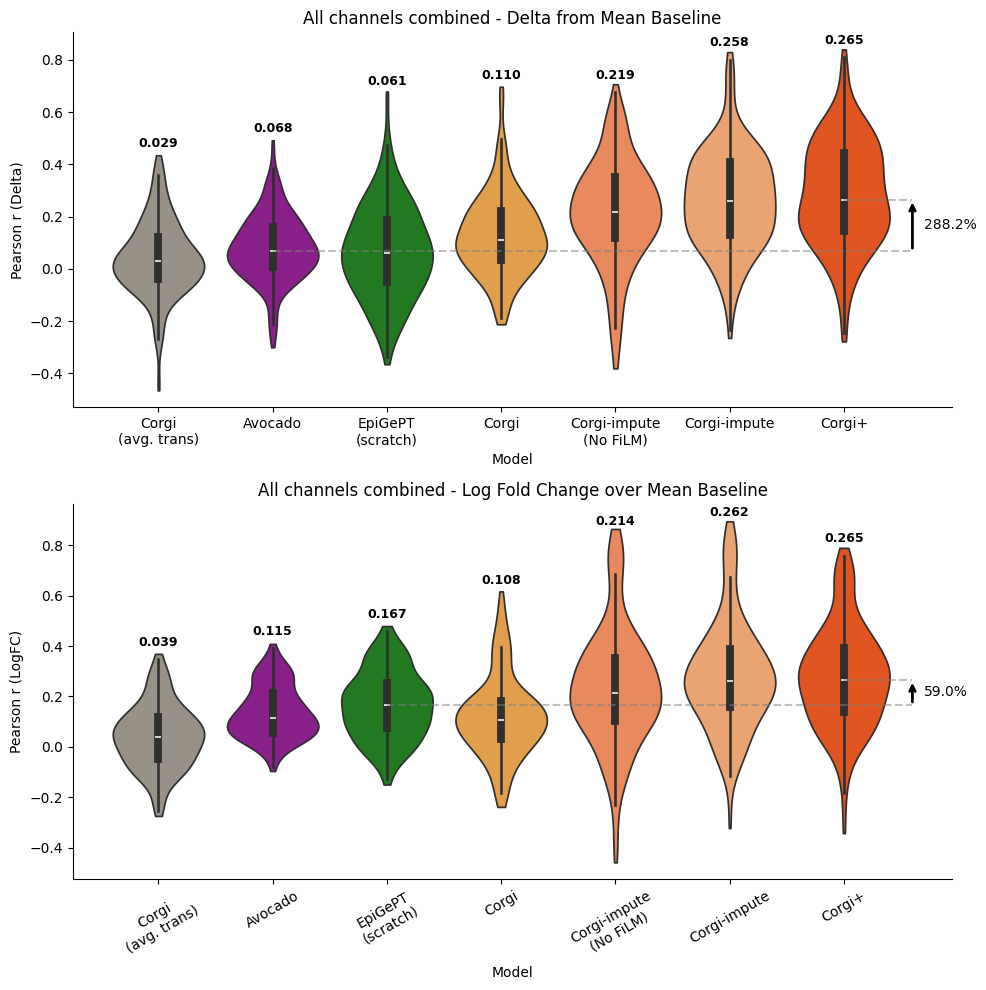

In [120]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
x_labels = ['Corgi\n(avg. trans)', 'Avocado', 'EpiGePT\n(scratch)', 'Corgi', 'Corgi-impute\n(No FiLM)', 'Corgi-impute', 'Corgi+']

# Delta plot
sns.violinplot(x='Model', y='Pearson r (Delta)', data=df_deltas_all, order=model_order, palette=colors, hue='Model', cut=0.4, ax=axes[0])
axes[0].set_title(f"All channels combined - Delta from Mean Baseline")

# Best model line
best_other_model_delta = max(df_deltas_all[df_deltas_all['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (Delta)'].median())
best_model_x = df_deltas_all[df_deltas_all['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (Delta)'].median().idxmax()
corgi_plus_median_delta = df_deltas_all[df_deltas_all['Model'] == 'Corgi+']['Pearson r (Delta)'].median()
improvement_delta = (corgi_plus_median_delta - best_other_model_delta) / abs(best_other_model_delta) * 100

# Dashed lines (begin at correct x)
axes[0].hlines(best_other_model_delta, xmin=model_names.index(best_model_x), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)
axes[0].hlines(corgi_plus_median_delta, xmin=model_names.index('Corgi+'), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)

# arrow must be perfectly vertical. from the baseline to Corgi+ median (one head)
axes[0].annotate("", xy=(6.6, best_other_model_delta), xytext=(6.6, corgi_plus_median_delta),
                    arrowprops=dict(arrowstyle="<-", color='black', lw=2))
axes[0].text(6.7, (best_other_model_delta + corgi_plus_median_delta) / 2, f"{improvement_delta:.1f}%", color='black', va='center')

# Write median values above each violin, when the top end of violin ends, so no overlaps.
for i, model in enumerate(model_order):
    median_val = df_deltas_all[df_deltas_all['Model'] == model]['Pearson r (Delta)'].median()
    top_end = df_deltas_all[df_deltas_all['Model'] == model]['Pearson r (Delta)'].max()
    axes[0].text(i, top_end + 0.04, f"{median_val:.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[0].set_xticklabels(x_labels)
plt.xticks(rotation=30)

# LogFC plot
sns.violinplot(x='Model', y='Pearson r (LogFC)', data=df_logfcs_all, order=model_order, palette=colors, hue='Model', cut=0.4, ax=axes[1])
axes[1].set_title(f"All channels combined - Log Fold Change over Mean Baseline")

# Best model line
best_other_model_logfc = max(df_logfcs_all[df_logfcs_all['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (LogFC)'].median())
best_model_x = df_logfcs_all[df_logfcs_all['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (LogFC)'].median().idxmax()
corgi_plus_median_logfc = df_logfcs_all[df_logfcs_all['Model'] == 'Corgi+']['Pearson r (LogFC)'].median()
improvement_logfc = (corgi_plus_median_logfc - best_other_model_logfc) / abs(best_other_model_logfc) * 100
# Dashed lines (begin at correct x)
axes[1].hlines(best_other_model_logfc, xmin=model_names.index(best_model_x), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)
axes[1].hlines(corgi_plus_median_logfc, xmin=model_names.index('Corgi+'), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)
# arrow must be perfectly vertical. from the baseline to Corgi+ median (one head)
axes[1].annotate("", xy=(6.6, best_other_model_logfc), xytext=(6.6, corgi_plus_median_logfc),
                    arrowprops=dict(arrowstyle="<-", color='black', lw=2))
axes[1].text(6.7, (best_other_model_logfc + corgi_plus_median_logfc) / 2, f"{improvement_logfc:.1f}%", color='black', va='center')
# Write median values above each violin, when the top end of violin ends, so no overlaps.
for i, model in enumerate(model_order):
    median_val = df_logfcs_all[df_logfcs_all['Model'] == model]['Pearson r (LogFC)'].median()
    top_end = df_logfcs_all[df_logfcs_all['Model'] == model]['Pearson r (LogFC)'].max()
    axes[1].text(i, top_end + 0.04, f"{median_val:.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[1].set_xticklabels(x_labels)
plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig(f"/project/deeprna/corgi-reproduction/figures_2/fig4_global.pdf", dpi=300)
plt.show()

/scratch/local/ipykernel_109210/2231938817.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
/scratch/local/ipykernel_109210/2231938817.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


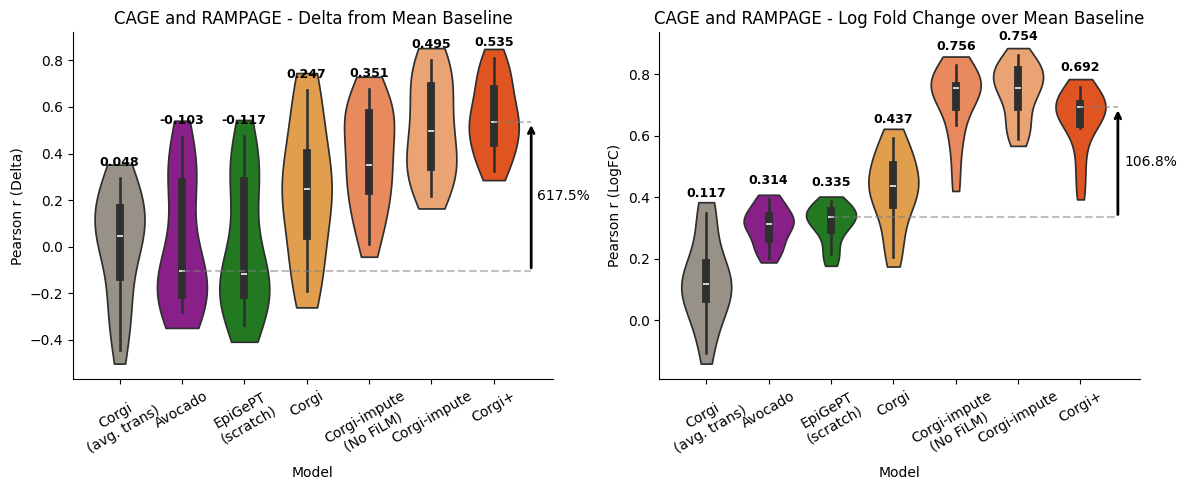

In [133]:
# One last plot combining CAGE and RAMPAGE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.4)

# 1st plot: delta
sns.violinplot(x='Model', y='Pearson r (Delta)', data=df_deltas_all[df_deltas_all['Channel'].isin(['cage_plus', 'rampage_plus'])],
               order=model_order, palette=colors, hue='Model', cut=0.4, ax=axes[0])
axes[0].set_title(f"CAGE and RAMPAGE - Delta from Mean Baseline")
# 2nd plot: logfc
sns.violinplot(x='Model', y='Pearson r (LogFC)', data=df_logfcs_all[df_logfcs_all['Channel'].isin(['cage_plus', 'rampage_plus'])],
               order=model_order, palette=colors, hue='Model', cut=0.4, ax=axes[1])
axes[1].set_title(f"CAGE and RAMPAGE - Log Fold Change over Mean Baseline")

# baseline lines, arrows, percentage improvements, x label rotation etc. as before, for both plots
x_labels = ['Corgi\n(avg. trans)', 'Avocado', 'EpiGePT\n(scratch)', 'Corgi', 'Corgi-impute\n(No FiLM)', 'Corgi-impute', 'Corgi+']
for ax, df, metric in zip(axes, [df_deltas_all, df_logfcs_all], ['Delta', 'LogFC']):
    df = df[df['Channel'].isin(['cage_plus', 'rampage_plus'])]
    best_other_model = max(df[df['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')[f'Pearson r ({metric})'].median())
    best_model_x = df[df['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')[f'Pearson r ({metric})'].median().idxmax()
    corgi_plus_median = df[df['Model'] == 'Corgi+'][f'Pearson r ({metric})'].median()
    improvement = (corgi_plus_median - best_other_model) / abs(best_other_model) * 100

    # Dashed lines (begin at correct x)
    ax.hlines(best_other_model, xmin=model_names.index(best_model_x), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)
    ax.hlines(corgi_plus_median, xmin=model_names.index('Corgi+'), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)

    # arrow must be perfectly vertical. from the baseline to Corgi+ median (one head)
    ax.annotate("", xy=(6.6, best_other_model), xytext=(6.6, corgi_plus_median),
                        arrowprops=dict(arrowstyle="<-", color='black', lw=2))
    ax.text(6.7, (best_other_model + corgi_plus_median) / 2, f"{improvement:.1f}%", color='black', va='center')

    # Write median values above each violin, when the top end of violin ends, so no overlaps.
    for i, model in enumerate(model_order):
        median_val = df[df['Model'] == model][f'Pearson r ({metric})'].median()
        top_end = df[df['Model'] == model][f'Pearson r ({metric})'].max()
        ax.text(i, top_end + 0.04, f"{median_val:.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticklabels(x_labels)
    plt.sca(ax)
    plt.xticks(rotation=30)

plt.tight_layout()
# plt.savefig(f"/project/deeprna/corgi-reproduction/figures_2/fig4_cage_rampage.pdf", dpi=300)
plt.show()

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


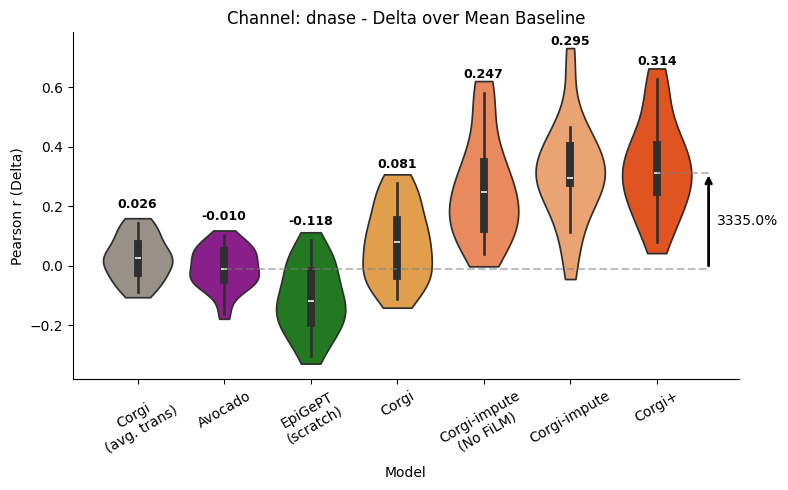

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


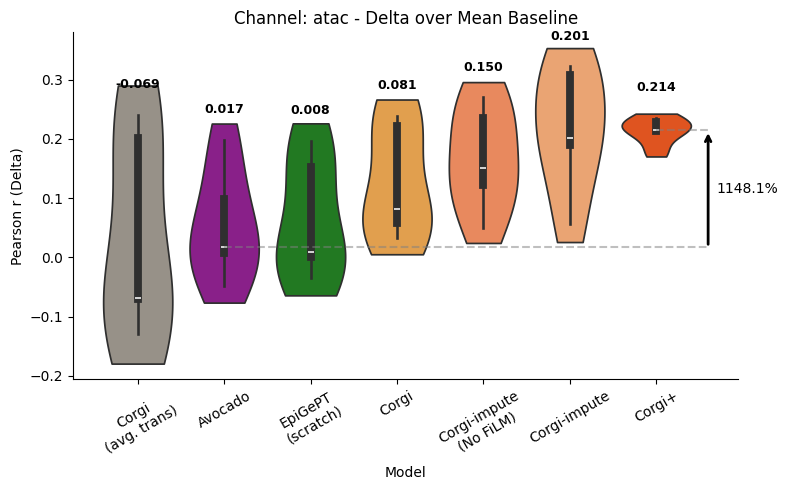

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


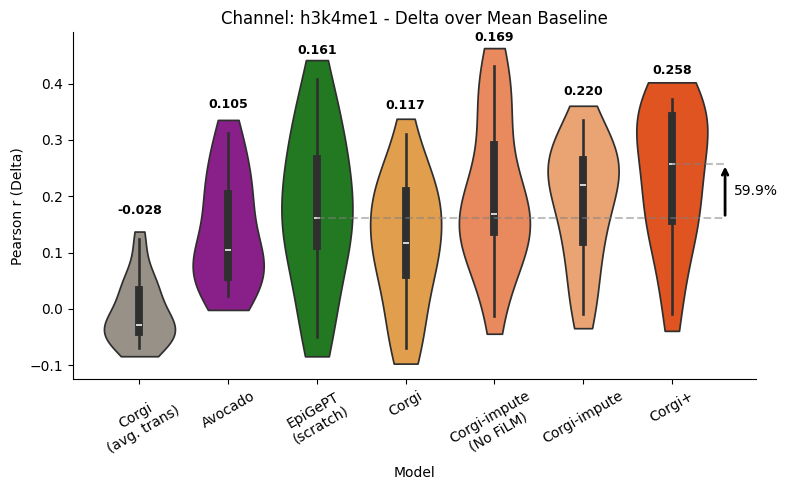

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


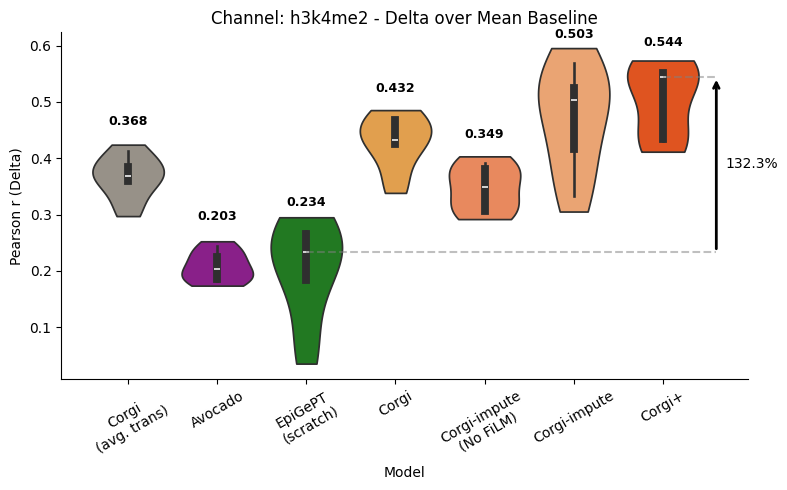

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


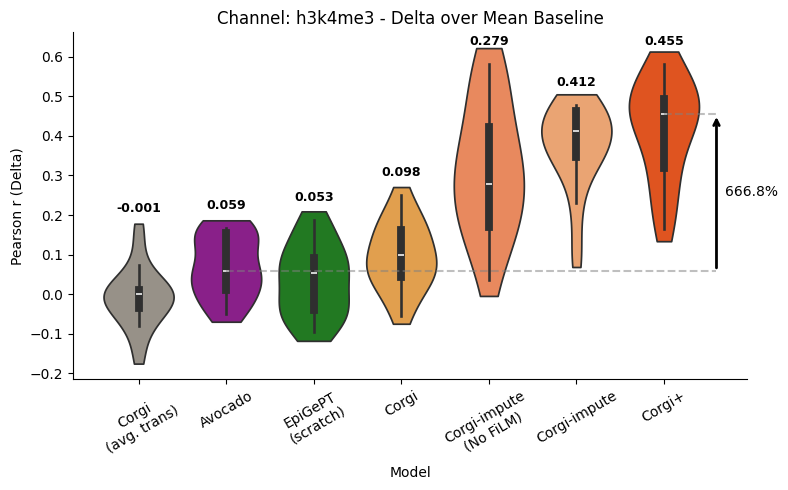

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


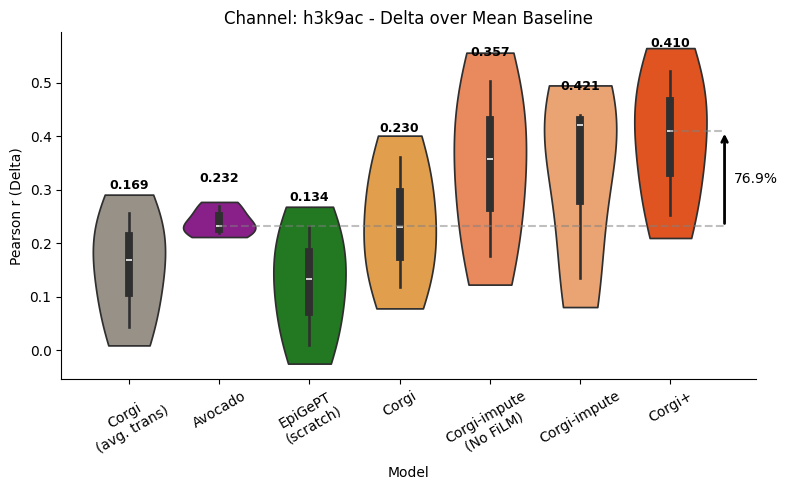

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


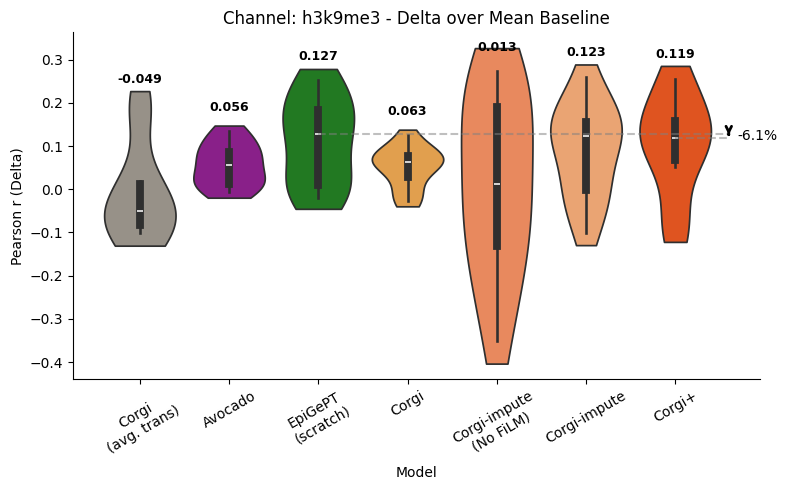

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


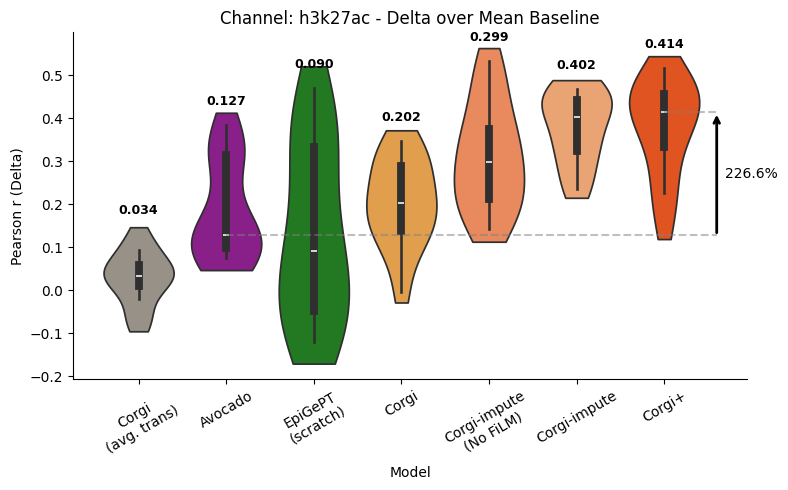

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


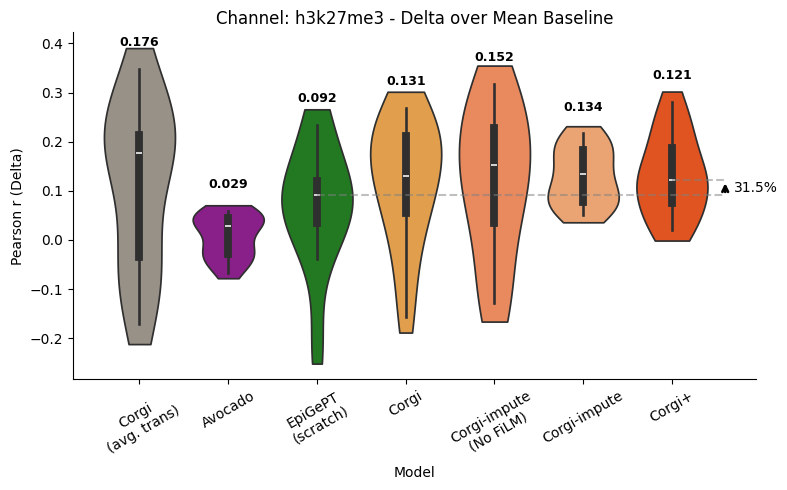

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


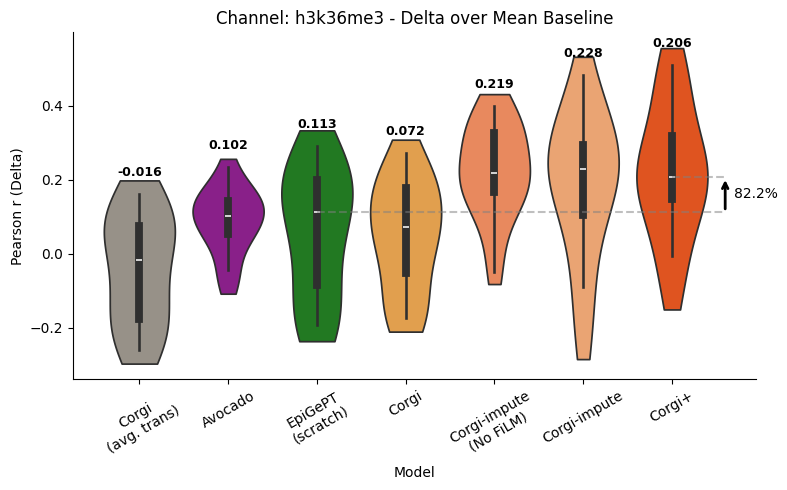

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


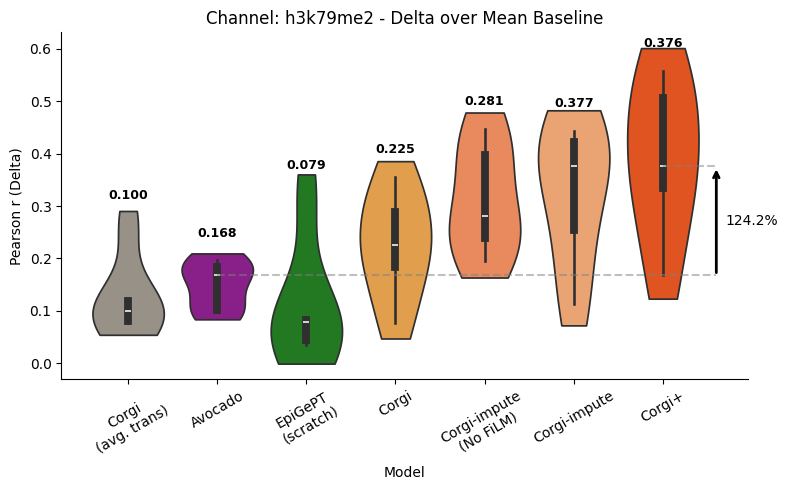

/scratch/local/ipykernel_109210/3805073836.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


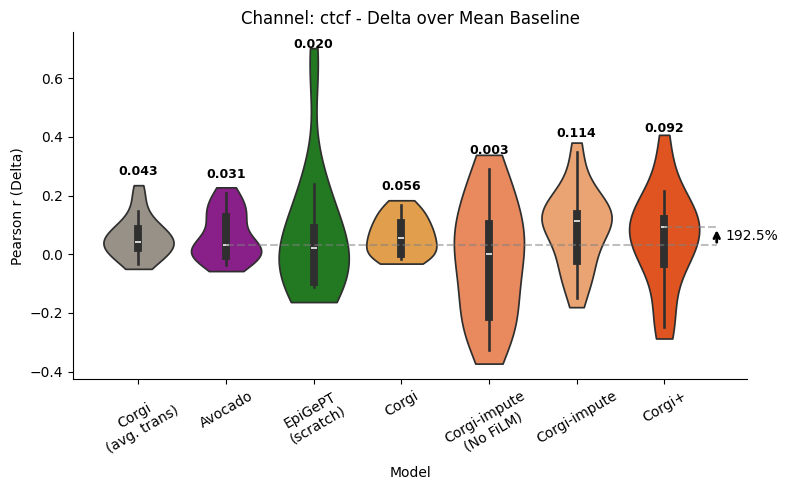

In [104]:
# One plot per channel. Boxplots showing distribution of correlations across tissues.
# show delta
# Order of models: corgi family in order (5 models), avocado, epigept
# All correlations at 128 bp resolution

model_names = ['Corgi avg. trans', 'Avocado', 'EpiGePT (scratch)', 'Corgi', 'Corgi-impute', 'Corgi-impute (No FiLM)', 'Corgi+']
model_order = ['Corgi avg. trans', 'Avocado', 'EpiGePT (scratch)', 'Corgi', 'Corgi-impute (No FiLM)', 'Corgi-impute', 'Corgi+']
# Colors: Corgi family orange shades, darkest is Corgi+. Epigept green, Avocado purple.
colors = ["#999286", "#9B0E9B", "#138813", "#FAA135", "#FEA15F", "#FF8147", '#FF4500']
channels = list(range(12))

for channel in channels:
    channel_name = data['experiments'][channel]
    corrs_delta = {model: [] for model in model_names}
    corrs_logfc = {model: [] for model in model_names}
    for tissue in range(data['ground_truth'].shape[2]):
        x_128 = data['ground_truth'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
        y_mean_128 = data['mean_baseline'][0, :, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)

        # Corgi family
        for i, model in enumerate(['Corgi avg. trans', 'Corgi', 'Corgi-impute', 'Corgi-impute (No FiLM)', 'Corgi+']):
            y_128 = data['corgi_family_preds'][i, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
            delta_x = x_128 - y_mean_128
            delta_y = y_128 - y_mean_128
            logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
            logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)

            r_delta, _ = pearsonr(delta_x, delta_y)
            r_logfc, _ = pearsonr(logfc_x, logfc_y)

            corrs_delta[model].append(r_delta)
            corrs_logfc[model].append(r_logfc)

        # Avocado
        y_128 = data['avocado_preds'][0, :, tissue, 72:6072, channel].flatten().reshape(-1, 2).mean(axis=1)
        delta_x = x_128 - y_mean_128
        delta_y = y_128 - y_mean_128
        logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)

        r_delta, _ = pearsonr(delta_x, delta_y)
        r_logfc, _ = pearsonr(logfc_x, logfc_y)

        corrs_delta['Avocado'].append(r_delta)
        corrs_logfc['Avocado'].append(r_logfc)

        # Epigept
        y_128 = data['epigept_preds'][0, :, tissue, :, channel].flatten()
        delta_x = x_128 - y_mean_128
        delta_y = y_128 - y_mean_128
        logfc_x = np.log(x_128 + 1) - np.log(y_mean_128 + 1)
        logfc_y = np.log(y_128 + 1) - np.log(y_mean_128 + 1)
        r_delta, _ = pearsonr(delta_x, delta_y)
        r_logfc, _ = pearsonr(logfc_x, logfc_y)
        corrs_delta['EpiGePT (scratch)'].append(r_delta)
        corrs_logfc['EpiGePT (scratch)'].append(r_logfc)

    # Convert to DataFrame for seaborn
    df_delta = pd.DataFrame({model: corrs_delta[model] for model in model_names})
    df_delta = df_delta.melt(var_name='Model', value_name='Pearson r (Delta)')
    # df_logfc = pd.DataFrame({model: corrs_logfc[model] for model in model_names})
    # df_logfc = df_logfc.melt(var_name='Model', value_name='Pearson r (LogFC)')

    # Plot
    fig, ax = plt.subplots(figsize=(8,5))
    sns.violinplot(x='Model', y='Pearson r (Delta)', data=df_delta, order=model_order, palette=colors, hue='Model', cut=0.4)
    ax.set_title(f"Channel: {channel_name} - Delta over Mean Baseline")

    # Find the best model from Avocado and Epigept. Then calculate percentage improvement between that and Corgi+
    # Draw transparent dashed line from the best model's median horizontally all the way to the right of the plot.
    # Draw a similar dashed line from Corgi+'s median to the right of the plot.
    # Draw an vertical arrow connecting the two. Write percentage improvement next to the arrow.
    # The dashed lines should begin at the x position at the best model, or Corgi+, and extend to the right edge of the plot.
    best_other_model_delta = max(df_delta[df_delta['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (Delta)'].median())
    # which model is it? (for x value)
    best_model_x = df_delta[df_delta['Model'].isin(['Avocado', 'EpiGePT (scratch)'])].groupby('Model')['Pearson r (Delta)'].median().idxmax()
    corgi_plus_median_delta = df_delta[df_delta['Model'] == 'Corgi+']['Pearson r (Delta)'].median()
    improvement_delta = (corgi_plus_median_delta - best_other_model_delta) / abs(best_other_model_delta) * 100

    # Dashed lines (begin at correct x)
    ax.hlines(best_other_model_delta, xmin=model_names.index(best_model_x), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)
    ax.hlines(corgi_plus_median_delta, xmin=model_names.index('Corgi+'), xmax=len(model_names)-0.4, colors='gray', linestyles='dashed', alpha=0.5)

    # arrow must be perfectly vertical. from the baseline to Corgi+ median (one head)
    ax.annotate("", xy=(6.6, best_other_model_delta), xytext=(6.6, corgi_plus_median_delta),
                        arrowprops=dict(arrowstyle="<-", color='black', lw=2))
    ax.text(6.7, (best_other_model_delta + corgi_plus_median_delta) / 2, f"{improvement_delta:.1f}%", color='black', va='center')

    # Write median values above each violin, when the top end of violin ends, so no overlaps.
    for i, model in enumerate(model_order):
        median_val = df_delta[df_delta['Model'] == model]['Pearson r (Delta)'].median()
        top_end = df_delta[df_delta['Model'] == model]['Pearson r (Delta)'].max()
        ax.text(i, top_end + 0.04, f"{median_val:.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    # X labels rotation
    x_labels = ['Corgi\n(avg. trans)', 'Avocado', 'EpiGePT\n(scratch)', 'Corgi', 'Corgi-impute\n(No FiLM)', 'Corgi-impute', 'Corgi+']
    ax.set_xticklabels(x_labels)
    plt.xticks(rotation=30)

    plt.tight_layout()
    plt.savefig(f"/project/deeprna/corgi-reproduction/figures_2/fig4c_channel_{channel}_delta.pdf", dpi=300)
    plt.show()